# Diving into @ormcache  / @ormcache_context

## *(from odoo.tools import ormcache, ormcache_context)*

## Odoo LRU Cache *(LRU - least recently used)*

### Common situation in Odoo sources

In [ ]:
from odoo import models


class ProductTemplate(models.Model):
    _name = "product.template"
    _inherit = ['mail.thread', 'mail.activity.mixin', 'image.mixin']
    _description = "Product Template"
    _order = "name"

    @tools.ormcache()
    def _get_default_category_id(self):
        # Deletion forbidden (at least through unlink)
        return self.env.ref('product.product_category_all')
    
    @tools.ormcache('self.id', 'frozenset(filtered_combination.ids)')
    def _get_variant_id_for_combination(self, filtered_combination):
        """See `_get_variant_for_combination`. This method returns an ID
        so it can be cached.

        Use sudo because the same result should be cached for all users.
        """
        self.ensure_one()
        domain = [('product_tmpl_id', '=', self.id)]
        combination_indices_ids = filtered_combination._ids2str()

        if combination_indices_ids:
            domain = expression.AND([domain, [('combination_indices', '=', combination_indices_ids)]])
        else:
            domain = expression.AND([domain, [('combination_indices', 'in', ['', False])]])

        return self.env['product.product'].sudo().with_context(active_test=False).search(domain, order='active DESC', limit=1).id

    @tools.ormcache('self.id')
    def _get_first_possible_variant_id(self):
        """See `_create_first_product_variant`. This method returns an ID
        so it can be cached."""
        self.ensure_one()
        return self._create_first_product_variant().id

<br></br>
<br></br>
### class ormcache: *( odoo/odoo/tools/cache.py )*

In [ ]:
from collections import Counter, defaultdict
from decorator import decorator
from inspect import signature
import logging

unsafe_eval = eval

_logger = logging.getLogger(__name__)


class ormcache_counter(object):
    """ Statistic counters for cache entries. """
    __slots__ = ['hit', 'miss', 'err']

    def __init__(self):
        self.hit = 0
        self.miss = 0
        self.err = 0

    @property
    def ratio(self):
        return 100.0 * self.hit / (self.hit + self.miss or 1)

# statistic counters dictionary, maps (dbname, modelname, method) to counter
STAT = defaultdict(ormcache_counter)


class ormcache(object):
    """ LRU cache decorator for model methods.
    The parameters are strings that represent expressions referring to the
    signature of the decorated method, and are used to compute a cache key::

        @ormcache('model_name', 'mode')
        def _compute_domain(self, model_name, mode="read"):
            ...

    For the sake of backward compatibility, the decorator supports the named
    parameter `skiparg`::

        @ormcache(skiparg=1)
        def _compute_domain(self, model_name, mode="read"):
            ...

    Methods implementing this decorator should never return a Recordset,
    because the underlying cursor will eventually be closed and raise a
    `psycopg2.OperationalError`.
    """
    def __init__(self, *args, **kwargs):
        self.args = args
        self.skiparg = kwargs.get('skiparg')

    def __call__(self, method):
        self.method = method
        self.determine_key()
        lookup = decorator(self.lookup, method)
        lookup.clear_cache = self.clear
        return lookup

    def determine_key(self):
        """ Determine the function that computes a cache key from arguments. """
        if self.skiparg is None:
            # build a string that represents function code and evaluate it
            args = str(signature(self.method))[1:-1]
            if self.args:
                code = "lambda %s: (%s,)" % (args, ", ".join(self.args))
            else:
                code = "lambda %s: ()" % (args,)
            self.key = unsafe_eval(code)
        else:
            # backward-compatible function that uses self.skiparg
            self.key = lambda *args, **kwargs: args[self.skiparg:]

    def lru(self, model):
        counter = STAT[(model.pool.db_name, model._name, self.method)]
        return model.pool._Registry__cache, (model._name, self.method), counter

    def lookup(self, method, *args, **kwargs):
        d, key0, counter = self.lru(args[0])
        key = key0 + self.key(*args, **kwargs)
        try:
            r = d[key]
            counter.hit += 1
            return r
        except KeyError:
            counter.miss += 1
            value = d[key] = self.method(*args, **kwargs)
            return value
        except TypeError:
            _logger.warning("cache lookup error on %r", key, exc_info=True)
            counter.err += 1
            return self.method(*args, **kwargs)

    def clear(self, model, *args):
        """ Clear the registry cache """
        model.pool._clear_cache()


class ormcache_context(ormcache):
    """ This LRU cache decorator is a variant of :class:`ormcache`, with an
    extra parameter ``keys`` that defines a sequence of dictionary keys. Those
    keys are looked up in the ``context`` parameter and combined to the cache
    key made by :class:`ormcache`.
    """
    def __init__(self, *args, **kwargs):
        super(ormcache_context, self).__init__(*args, **kwargs)
        self.keys = kwargs['keys']

    def determine_key(self):
        """ Determine the function that computes a cache key from arguments. """
        assert self.skiparg is None, "ormcache_context() no longer supports skiparg"
        # build a string that represents function code and evaluate it
        sign = signature(self.method)
        args = str(sign)[1:-1]
        cont_expr = "(context or {})" if 'context' in sign.parameters else "self._context"
        keys_expr = "tuple(%s.get(k) for k in %r)" % (cont_expr, self.keys)
        if self.args:
            code = "lambda %s: (%s, %s)" % (args, ", ".join(self.args), keys_expr)
        else:
            code = "lambda %s: (%s,)" % (args, keys_expr)
        self.key = unsafe_eval(code)

<br></br>
<br></br>
### Class as Decorator

In [64]:

class CLASS_DECORATOR:
    
    def __init__(self, *ar, **kw):
        print('__init__')
        self.ar = ar
        self.kw = kw
        
    def __call__(self, f):
        print('__call__')
        
        def wrapper(*args, **kwargs):
            print('__wrapper__')
            print('--------------')
            print('self args: %s' % str(self.ar))
            print('self kwargs: %s' % str(self.kw))
            print('--------------')
            print('foo args: %s' % str(args))
            print('foo kwargs: %s' % str(kwargs))
            print('--------------')
            
            f(*args, **kwargs)
        
        return wrapper


@CLASS_DECORATOR('a', 'b', c=42, d=404)
def foo(*args, **kwargs):
    print('__foo__')

__init__
__call__


In [65]:
foo('e', 'f', j=502)

__wrapper__
--------------
self args: ('a', 'b')
self kwargs: {'d': 404, 'c': 42}
--------------
foo args: ('e', 'f')
foo kwargs: {'j': 502}
--------------
__foo__


<br></br>
<br></br>
### class Registry: *( odoo/odoo/modules/registry.py )*

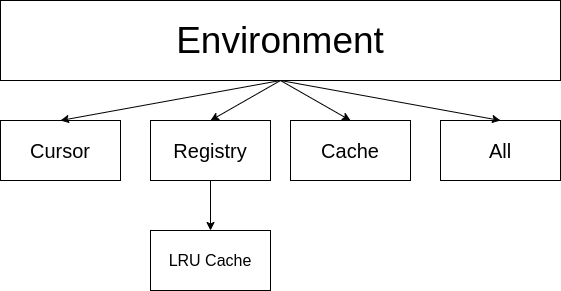

### Envoronment.Cache: """ Implementation of the cache of records. """

### Registry.LRU_Cache: """ LRU cache decorator for model methods. """

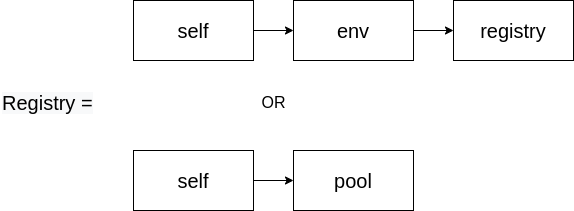

In [ ]:
from collections.abc import Mapping
from odoo.tools.lru import LRU


class Registry(Mapping):
    """ Model registry for a particular database.

    The registry is essentially a mapping between model names and model classes.
    There is one registry instance per database.

    """
    _lock = threading.RLock()
    _saved_lock = None
  
    def __new__(cls, db_name):
        """ Return the registry for the given database name."""
        with cls._lock:
            try:
                return cls.registries[db_name]
            except KeyError:
                return cls.new(db_name)
            finally:
                # set db tracker - cleaned up at the WSGI dispatching phase in
                # odoo.service.wsgi_server.application
                threading.current_thread().dbname = db_name

    @classmethod
    def new(cls, db_name, force_demo=False, status=None, update_module=False):
        """ Create and return a new registry for the given database name. """
        with cls._lock:
            with odoo.api.Environment.manage():
                registry = object.__new__(cls)
                registry.init(db_name)

                # Initializing a registry will call general code which will in
                # turn call Registry() to obtain the registry being initialized.
                # Make it available in the registries dictionary then remove it
                # if an exception is raised.
                cls.delete(db_name)
                cls.registries[db_name] = registry
                try:
                    registry.setup_signaling()
                    # This should be a method on Registry
                    try:
                        odoo.modules.load_modules(registry._db, force_demo, status, update_module)
                    except Exception:
                        odoo.modules.reset_modules_state(db_name)
                        raise
                except Exception:
                    _logger.error('Failed to load registry')
                    del cls.registries[db_name]
                    raise

                # load_modules() above can replace the registry by calling
                # indirectly new() again (when modules have to be uninstalled).
                # Yeah, crazy.
                registry = cls.registries[db_name]

            registry._init = False
            registry.ready = True
            registry.registry_invalidated = bool(update_module)

        return registry

    def init(self, db_name):
        self.models = {}    # model name/model instance mapping
        self._sql_constraints = set()
        self._init = True
        self._assertion_report = odoo.tests.runner.OdooTestResult()
        self._fields_by_model = None
        self._ordinary_tables = None
        self._constraint_queue = deque()
        self.__cache = LRU(8192)

        # modules fully loaded (maintained during init phase by `loading` module)
        self._init_modules = set()
        self.updated_modules = []       # installed/updated modules
        self.loaded_xmlids = set()

        self.db_name = db_name
        self._db = odoo.sql_db.db_connect(db_name)

        # cursor for test mode; None means "normal" mode
        self.test_cr = None
        self.test_lock = None

        # Indicates that the registry is
        self.loaded = False             # whether all modules are loaded
        self.ready = False              # whether everything is set up

        # Inter-process signaling:
        # The `base_registry_signaling` sequence indicates the whole registry
        # must be reloaded.
        # The `base_cache_signaling sequence` indicates all caches must be
        # invalidated (i.e. cleared).
        self.registry_sequence = None
        self.cache_sequence = None

        # Flags indicating invalidation of the registry or the cache.
        self.registry_invalidated = False
        self.cache_invalidated = False

        with closing(self.cursor()) as cr:
            self.has_unaccent = odoo.modules.db.has_unaccent(cr)

    def _clear_cache(self):
        """ Clear the cache and mark it as invalidated. """
        self.__cache.clear()
        self.cache_invalidated = True

    def clear_caches(self):
        """ Clear the caches associated to methods decorated with
        ``tools.ormcache`` or ``tools.ormcache_multi`` for all the models.
        """
        for model in self.models.values():
            model.clear_caches()


In [ ]:
lru_cache_dict = self.env.registry._Registry__cache.d
lru_cache_dict = self.pool._Registry__cache.d

#### Clear cache in BaseModel class:

In [ ]:
class BaseModel(MetaModel('DummyModel', (object,), {'_register': False})):

    @classmethod
    def clear_caches(cls):
        """ Clear the caches

        This clears the caches associated to methods decorated with
        ``tools.ormcache`` or ``tools.ormcache_multi``.
        """
        cls.pool._clear_cache()

<br></br>
<br></br>
### class LRU *( odoo/odoo/tools/lru.py )*

In [ ]:
import collections
import threading

from .func import synchronized

__all__ = ['LRU']

class LRU(object):
    """
    Implementation of a length-limited O(1) LRU map.

    Original Copyright 2003 Josiah Carlson, later rebuilt on OrderedDict.
    """
    def __init__(self, count, pairs=()):
        self._lock = threading.RLock()
        self.count = max(count, 1)
        self.d = collections.OrderedDict()
        for key, value in pairs:
            self[key] = value

    @synchronized()
    def __contains__(self, obj):
        return obj in self.d

    def get(self, obj, val=None):
        try:
            return self[obj]
        except KeyError:
            return val

    @synchronized()
    def __getitem__(self, obj):
        a = self.d[obj]
        self.d.move_to_end(obj, last=False)
        return a

    @synchronized()
    def __setitem__(self, obj, val):
        self.d[obj] = val
        self.d.move_to_end(obj, last=False)
        while len(self.d) > self.count:
            self.d.popitem(last=True)

    @synchronized()
    def __delitem__(self, obj):
        del self.d[obj]

    @synchronized()
    def __len__(self):
        return len(self.d)

    @synchronized()
    def pop(self,key):
        return self.d.pop(key)

    @synchronized()
    def clear(self):
        self.d.clear()


<br></br>
### synchronized *( odoo/odoo/tools/func.py )*

In [ ]:
def synchronized(lock_attr='_lock'):
    def decorator(func):
        @wraps(func)
        def wrapper(self, *args, **kwargs):
            lock = getattr(self, lock_attr)
            try:
                lock.acquire()
                return func(self, *args, **kwargs)
            finally:
                lock.release()
        return wrapper
    return decorator

<br></br>
### Understanding Lock / Rlock in Python

[Python Lock Objects](https://docs.python.org/3/library/threading.html#lock-objects)

[Python R-Lock Objects](https://docs.python.org/3/library/threading.html#rlock-objects)

[Cинхронизации потоков в Python](https://python-scripts.com/synchronization-between-threads)

<br></br>
<br></br>
 ## Let's try it on Odoo UI